### What we will learn

- We will build our first HelloWorld Kubeflow Pipeline!
- We will show how to compile pipeline function into template
- We will push template into Artifact Repository
- We will show how to execute Pipeline Job using Vertex AI SDK
- We will show how to execute Pipeline Job from templates uploaded to Artifact Repository using Vertex AI

In [50]:
import kfp

In [51]:
import kfp
print('KFP SDK version: {}'.format(kfp.__version__))

KFP SDK version: 2.0.0-beta.12


In [52]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [53]:
! pwd

/home/jupyter/ccc


In [54]:
import os


BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')


print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)


PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1


In [55]:
from kfp.dsl import component

In [56]:
@component
def helloworld():
    print("Hello World")

In [57]:
from kfp.dsl import pipeline

@pipeline(name="wf-ccc-ex1")
def pipeline():
    task = helloworld()

### Compile and run pipeline

In [58]:
from kfp import compiler

In [59]:
PIPELINE_PARAMETERS = {}

LABELS = {}

ENABLE_CACHING=True

In [60]:
dag_yaml_filename = f"dag_{PREFIX}_ex1.yaml"

compiler.Compiler().compile(
   pipeline_func=pipeline,        ##input
   package_path=dag_yaml_filename ##output
)

In [61]:
from google.cloud import aiplatform

job = aiplatform.PipelineJob(display_name = f"kfp_pipeline_{PREFIX}_ex1",
                             template_path = dag_yaml_filename,
                             pipeline_root = PIPELINE_ROOT,
                             parameter_values = PIPELINE_PARAMETERS, ## Make sure PIPELINE_PARAMETERS collection does not include parameters that are unknown to pipeline
                             enable_caching = ENABLE_CACHING,
                             #encryption_spec_key_name = CMEK,
                             labels = LABELS,
                             project = VERTEXAI_PROJECT_ID,
                             location = VERTEXAI_REGION)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

Creating PipelineJob


KeyboardInterrupt: 

### Upload pipeline template to Artifact Registry (Kubeflow Pipeline)

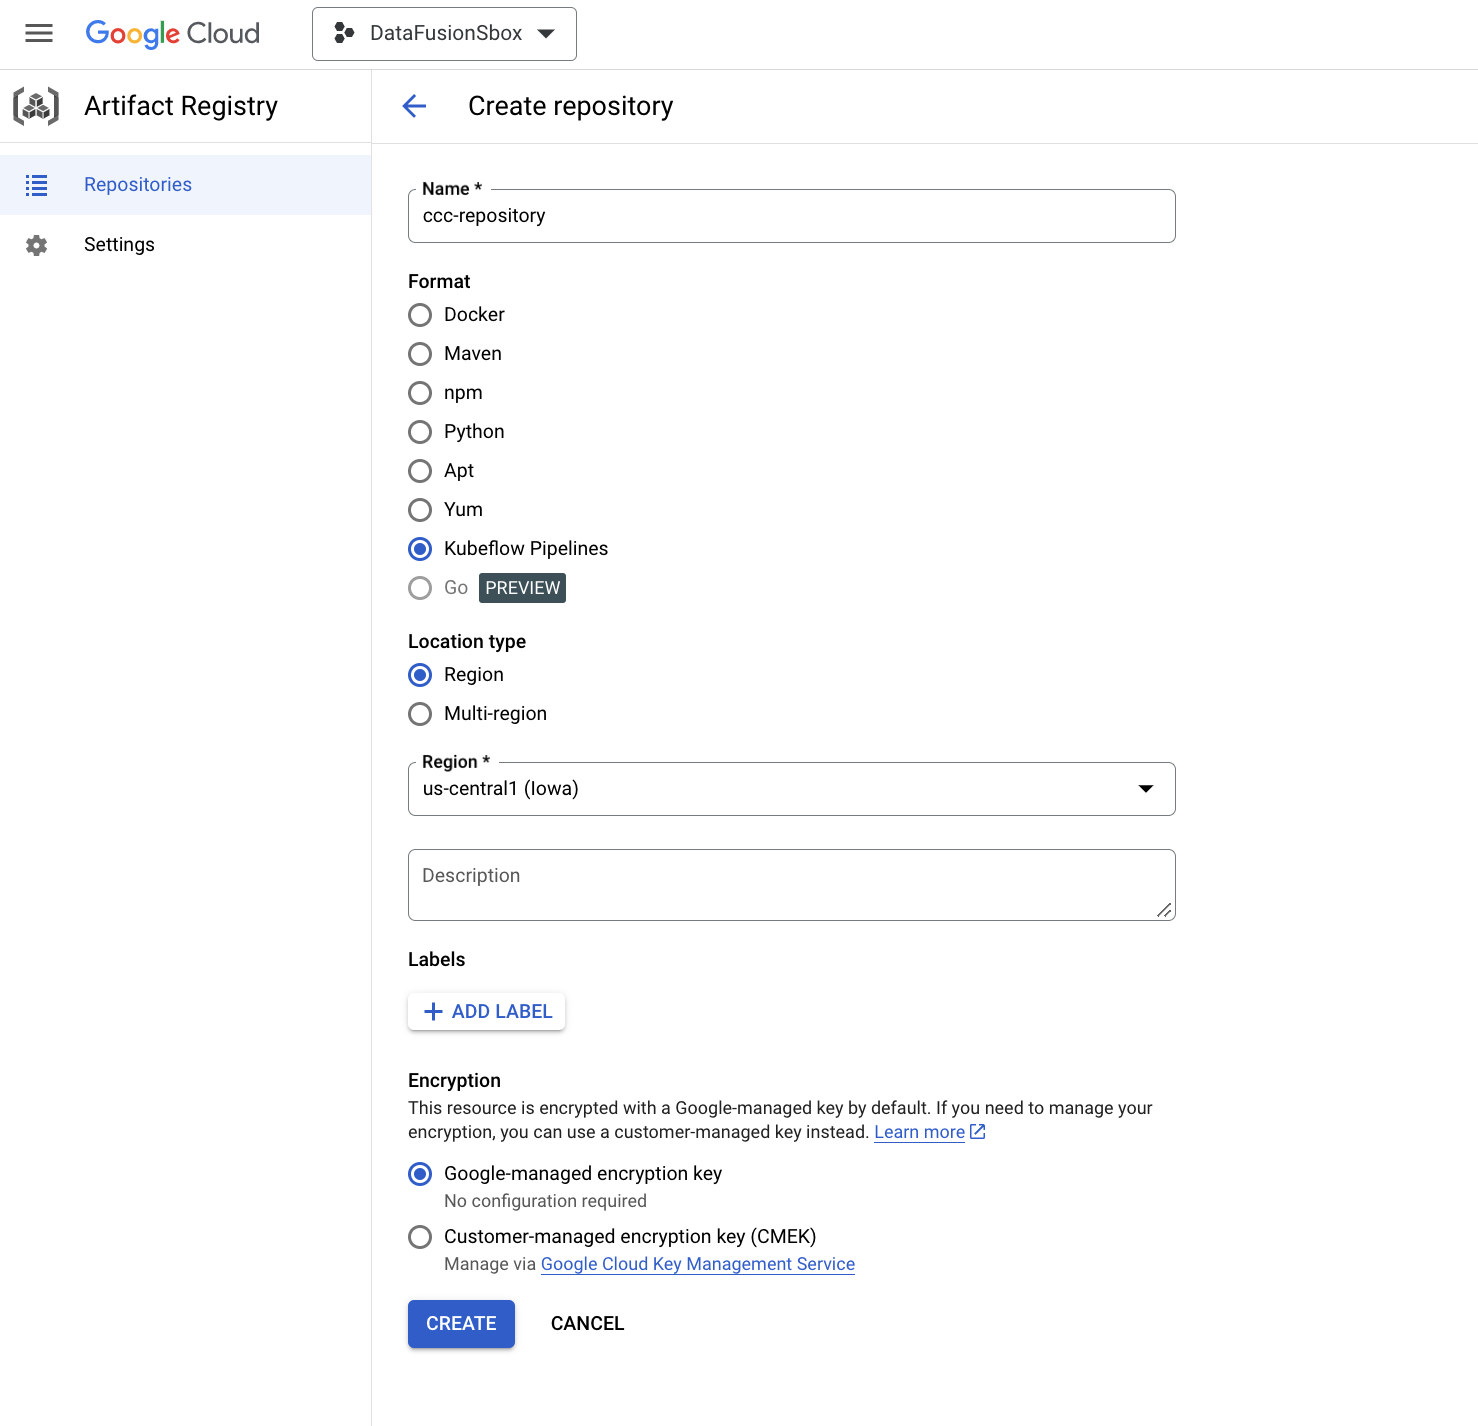

In [62]:
GCP_ARTIFACT_REPO_NAME=f"{PREFIX}-kfp-repository"

In [63]:
from kfp.registry import RegistryClient

In [64]:
client = RegistryClient(host=f"https://{VERTEXAI_REGION}-kfp.pkg.dev/{VERTEXAI_PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}")

In [65]:
templateName, versionName = client.upload_pipeline(
  file_name=dag_yaml_filename,
  tags = ["v1", "latest"]
)

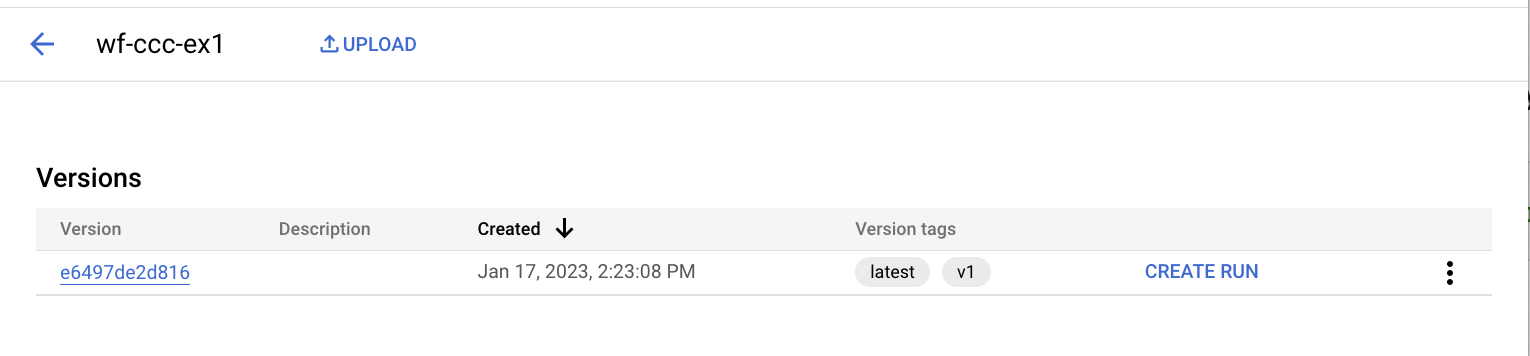

In [66]:
packages = client.list_packages()
packages

[{'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-kfp-repository/packages/wf-ccc-ex1',
  'createTime': '2023-02-27T09:36:45.853327Z',
  'updateTime': '2023-02-27T10:23:19.071967Z'}]

In [67]:
versions = client.list_versions(package_name = packages[0]['name'].split('/')[-1])
versions

[{'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-kfp-repository/packages/wf-ccc-ex1/versions/sha256:a8e2063a0b696278231c434b9289d8a7f4e935bc499ba95f8d84e4cd8da1c70d',
  'createTime': '2023-02-27T09:36:45.853327Z',
  'updateTime': '2023-02-27T10:23:19.071967Z',
  'relatedTags': [{'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-kfp-repository/packages/wf-ccc-ex1/tags/latest',
    'version': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-kfp-repository/packages/wf-ccc-ex1/versions/sha256:a8e2063a0b696278231c434b9289d8a7f4e935bc499ba95f8d84e4cd8da1c70d'},
   {'name': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-kfp-repository/packages/wf-ccc-ex1/tags/v1',
    'version': 'projects/datafusionsbox/locations/us-central1/repositories/ccc-kfp-repository/packages/wf-ccc-ex1/versions/sha256:a8e2063a0b696278231c434b9289d8a7f4e935bc499ba95f8d84e4cd8da1c70d'}]}]

In [68]:
artifact_name = dag_json_filename.split('.')[0]
artifact_name

'dag_ccc_ex1'

In [69]:
package_name = packages[0]['name'].split('/')[-1]
package_name

'wf-ccc-ex1'

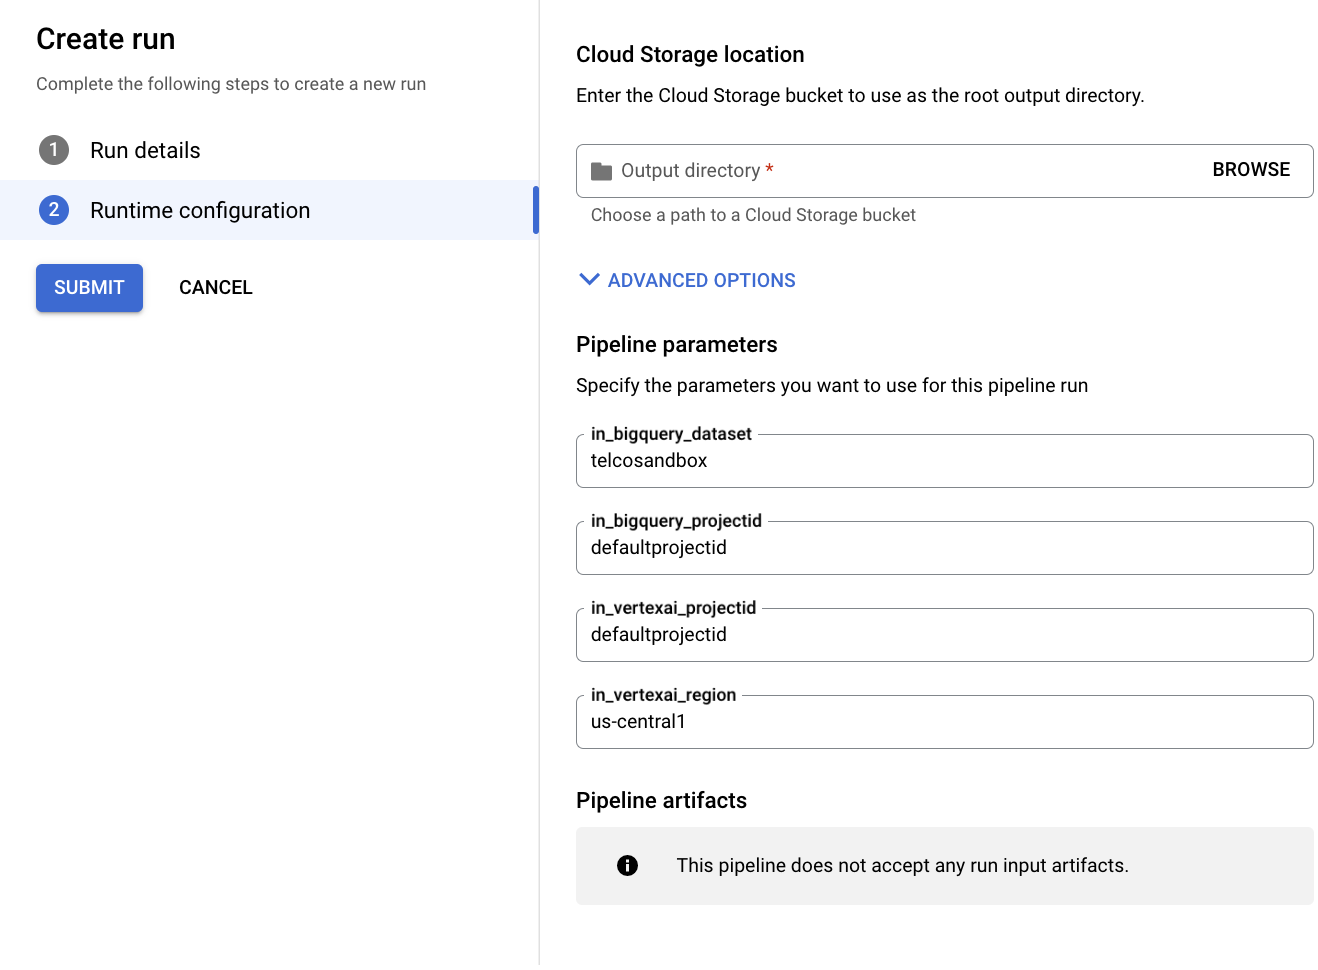

## Run pipeline template (specific version)

In [70]:
from google.cloud import aiplatform
versionName = versions[0]['name'].split('/')[-1]

template_path = f"https://{VERTEXAI_REGION}-kfp.pkg.dev/{VERTEXAI_PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}/{package_name}/{versionName}"
print(template_path)

job = aiplatform.PipelineJob(
    display_name="hello-world-latest",
    template_path=f"https://{VERTEXAI_REGION}-kfp.pkg.dev/{VERTEXAI_PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}/{package_name}/{versionName}"
)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

https://us-central1-kfp.pkg.dev/datafusionsbox/ccc-kfp-repository/wf-ccc-ex1/sha256:a8e2063a0b696278231c434b9289d8a7f4e935bc499ba95f8d84e4cd8da1c70d
Creating PipelineJob
PipelineJob created. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230227102335
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230227102335')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/wf-ccc-ex1-20230227102335?project=339239659794
PipelineJob run completed. Resource name: projects/339239659794/locations/us-central1/pipelineJobs/wf-ccc-ex1-20230227102335


## Run pipeline template (specific tag)

In [16]:
from google.cloud import aiplatform
tagName = "latest"
template_path = f"https://{VERTEXAI_REGION}-kfp.pkg.dev/{VERTEXAI_PROJECT_ID}/{GCP_ARTIFACT_REPO_NAME}/{package_name}/{tagName}"
print(template_path)
job = aiplatform.PipelineJob(
    display_name="hello-world-latest",
    template_path=template_path,
    parameter_values = PIPELINE_PARAMETERS, ## Make sure PIPELINE_PARAMETERS collection does not include parameters that are unknown to pipeline
    enable_caching = ENABLE_CACHING,
    #encryption_spec_key_name = CMEK,
    labels = LABELS,
    project = VERTEXAI_PROJECT_ID,
    location = VERTEXAI_REGION
)

job.run(service_account="339239659794-compute@developer.gserviceaccount.com")

https://us-central1-kfp.pkg.dev/datafusionsbox/ccc-workshop-vertexai-pipelines/dag_ccc_ex1/latest


HTTPError: HTTP Error 404: Not Found